In [9]:
import gym
import numpy as np

from functions import *
from numpy import load
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import StandardScaler
from numpy import save
from numpy import load
from sklearn import preprocessing
import math

In [10]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [11]:
def discretization(env, state):
    
    #states (observation) lower limit
    #2 dimensions: 
    #1st dimension = lower limit of position (1st state)
    #2nd dimension = lower limit of velocity (2nd state)
    env_low = env.observation_space.low
    
    #states (observaion) upper limit
    #2 dimensions: 
    #1st dimension = upper limit of position (1st state)
    #2nd dimension = upper limit of velocity (2nd state)
    env_high = env.observation_space.high
    
    #Interval for each state based on n_states
    #2 dimensions:
    #1st dimension: interval of position (1st state)
    #2nd dimension: interval of velocity (2nd state)
    env_den = (env_high - env_low)/n_states
    
    position_den = env_den[0]
    velocity_den = env_den[1]
    
    position_high = env_high[0]
    position_low = env_low[0]
    
    velocity_high = env_high[1]
    velocity_low = env_low[1]
    
    #scale the new/next state 
    position_scaled = int((state[0] - position_low)/position_den)
    velocity_scaled = int((state[1] - velocity_low)/velocity_den)
    
    return position_scaled, velocity_scaled

In [12]:
def rbf_transform(data,center,sigma):
    return np.exp(-(np.linalg.norm(data-center)**2) / sigma**2)

In [13]:
def generate_samples(env,n):
    sample_states = []

    for i in range(n):
        state = env.observation_space.sample()
        state = list(state)
        sample_states.append(state)

    sample_states = np.array(sample_states)
    
    scalerX = preprocessing.StandardScaler().fit(sample_states)

    sample_states = scalerX.transform(sample_states)
    
    return sample_states, scalerX

In [14]:
def predict(s0,s1,w,centers,std,scaler):
    x = np.array([[state[0],state[1]]])
    x = scaler.transform(x)
    x = np.array([x[0][0],x[0][1]])
    
    RBF = np.array([[rbf_transform(x,c,std) for c in centers]])
    RBF = np.reshape(RBF, (-1,1))

    out = RBF.T@w
    
    return RBF, out

In [15]:
#writer = SummaryWriter()

In [16]:
env_name = 'MountainCar-v0'
env = gym.make(env_name)
state = env.reset()

env = env.unwrapped
env.seed()
np.random.seed(0)

In [17]:
sample_states, scalerX = generate_samples(env,5000)

C = 100
kmeans = KMeans(n_clusters=C, random_state=567).fit(sample_states)

std = np.std(sample_states)
centers = kmeans.cluster_centers_

In [20]:
centers.shape

(100, 2)

In [10]:
#q_table = np.zeros((n_states, n_states, env.action_space.n))

In [11]:
n_states = 40
episodes = 1000
gamma = 0.95

In [12]:
lr = 0.001
min_lr = 0.001

epsilon = 0.1
min_epsilon = 0.02

w = np.random.rand(C,3)

episode_epsilon = []
all_rewards = []
errors = []
episode_steps = []
for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    
    if episode%50 == 0 and episode != 0:
        #lr = lr*0.5
        epsilon = epsilon*0.9  

    lr = max(min_lr, lr)
    epsilon = max(min_epsilon, epsilon)
    
    steps = 0
    
    print('Episode:',episode, 'lr:', lr, 'epsilon:',epsilon)
    
    losses = []
    while True:
        env.render()
        
        RBF, out = predict(state[0],state[1],w,centers,std,scalerX)

        if np.random.uniform(low=0, high=1)<epsilon:
            a = np.random.choice(env.action_space.n)
        else:
            a = np.argmax(out)

        state, reward, terminate, _ = env.step(a)
        
        RBF_next, out_next = predict(state[0],state[1],w,centers,std,scalerX)
        
        #SARSA update rule
        #=====================================================
        if np.random.uniform(low=0, high=1)<epsilon:
            a2 = np.random.choice(env.action_space.n)
        else:
            a2 = np.argmax(out_next)
        
        target = out.copy()
        target[0][a] = reward + gamma*out_next[0][a2]
        
        #=====================================================
        
        error = np.sum(np.abs(target - out))
        
        loss = target - out
        
        derivative = (-RBF) @ loss
        
        w = w - lr*derivative

        total_reward += reward
        steps += 1
        
        losses.append(error)
        

        if terminate:
            break
    
    episode_epsilon.append(epsilon)
    all_rewards.append(total_reward)
    errors.append(np.mean(losses))
    episode_steps.append(steps)
    
    print('Episode', episode, 'Total reward:', total_reward, 'Steps:', steps, 'Loss:',np.mean(losses))

env.close()
#writer.close() 

Episode: 0 lr: 0.001 epsilon: 0.1
Episode 0 Total reward: -1254.0 Steps: 1254 Loss: 1.4171991178455878
Episode: 1 lr: 0.001 epsilon: 0.1
Episode 1 Total reward: -17270.0 Steps: 17270 Loss: 0.8182695454284082
Episode: 2 lr: 0.001 epsilon: 0.1
Episode 2 Total reward: -448.0 Steps: 448 Loss: 0.2879363397321967
Episode: 3 lr: 0.001 epsilon: 0.1
Episode 3 Total reward: -456.0 Steps: 456 Loss: 0.23116160241041167
Episode: 4 lr: 0.001 epsilon: 0.1
Episode 4 Total reward: -421.0 Steps: 421 Loss: 0.22762738608782226
Episode: 5 lr: 0.001 epsilon: 0.1
Episode 5 Total reward: -338.0 Steps: 338 Loss: 0.19443992644964614
Episode: 6 lr: 0.001 epsilon: 0.1
Episode 6 Total reward: -390.0 Steps: 390 Loss: 0.22475117049099752
Episode: 7 lr: 0.001 epsilon: 0.1
Episode 7 Total reward: -346.0 Steps: 346 Loss: 0.24494021839047783
Episode: 8 lr: 0.001 epsilon: 0.1
Episode 8 Total reward: -281.0 Steps: 281 Loss: 0.19994049900415897
Episode: 9 lr: 0.001 epsilon: 0.1
Episode 9 Total reward: -293.0 Steps: 293 Los

Episode 75 Total reward: -148.0 Steps: 148 Loss: 0.21365529096975705
Episode: 76 lr: 0.001 epsilon: 0.09000000000000001
Episode 76 Total reward: -374.0 Steps: 374 Loss: 0.17129676320639964
Episode: 77 lr: 0.001 epsilon: 0.09000000000000001
Episode 77 Total reward: -157.0 Steps: 157 Loss: 0.22186045763906362
Episode: 78 lr: 0.001 epsilon: 0.09000000000000001
Episode 78 Total reward: -449.0 Steps: 449 Loss: 0.17184142467422
Episode: 79 lr: 0.001 epsilon: 0.09000000000000001
Episode 79 Total reward: -840.0 Steps: 840 Loss: 0.12476690537232539
Episode: 80 lr: 0.001 epsilon: 0.09000000000000001
Episode 80 Total reward: -2081.0 Steps: 2081 Loss: 0.08857673018435232
Episode: 81 lr: 0.001 epsilon: 0.09000000000000001
Episode 81 Total reward: -145.0 Steps: 145 Loss: 0.1645463690543186
Episode: 82 lr: 0.001 epsilon: 0.09000000000000001
Episode 82 Total reward: -1283.0 Steps: 1283 Loss: 0.07787285822113539
Episode: 83 lr: 0.001 epsilon: 0.09000000000000001
Episode 83 Total reward: -322.0 Steps: 3

Episode 143 Total reward: -218.0 Steps: 218 Loss: 0.12947072173298707
Episode: 144 lr: 0.001 epsilon: 0.08100000000000002
Episode 144 Total reward: -514.0 Steps: 514 Loss: 0.08256241751645947
Episode: 145 lr: 0.001 epsilon: 0.08100000000000002
Episode 145 Total reward: -152.0 Steps: 152 Loss: 0.18273351070190935
Episode: 146 lr: 0.001 epsilon: 0.08100000000000002
Episode 146 Total reward: -311.0 Steps: 311 Loss: 0.09397257216005636
Episode: 147 lr: 0.001 epsilon: 0.08100000000000002
Episode 147 Total reward: -443.0 Steps: 443 Loss: 0.0810538468511994
Episode: 148 lr: 0.001 epsilon: 0.08100000000000002
Episode 148 Total reward: -152.0 Steps: 152 Loss: 0.15903660977753792
Episode: 149 lr: 0.001 epsilon: 0.08100000000000002
Episode 149 Total reward: -150.0 Steps: 150 Loss: 0.19717403106505663
Episode: 150 lr: 0.001 epsilon: 0.07290000000000002
Episode 150 Total reward: -154.0 Steps: 154 Loss: 0.1967186187372381
Episode: 151 lr: 0.001 epsilon: 0.07290000000000002
Episode 151 Total reward: 

Episode 211 Total reward: -144.0 Steps: 144 Loss: 0.13394374265272554
Episode: 212 lr: 0.001 epsilon: 0.06561000000000002
Episode 212 Total reward: -155.0 Steps: 155 Loss: 0.10932981347509264
Episode: 213 lr: 0.001 epsilon: 0.06561000000000002
Episode 213 Total reward: -146.0 Steps: 146 Loss: 0.13316216217105406
Episode: 214 lr: 0.001 epsilon: 0.06561000000000002
Episode 214 Total reward: -146.0 Steps: 146 Loss: 0.12314238143903515
Episode: 215 lr: 0.001 epsilon: 0.06561000000000002
Episode 215 Total reward: -145.0 Steps: 145 Loss: 0.11542211958064594
Episode: 216 lr: 0.001 epsilon: 0.06561000000000002
Episode 216 Total reward: -148.0 Steps: 148 Loss: 0.15707960438195742
Episode: 217 lr: 0.001 epsilon: 0.06561000000000002
Episode 217 Total reward: -145.0 Steps: 145 Loss: 0.11884275674717848
Episode: 218 lr: 0.001 epsilon: 0.06561000000000002
Episode 218 Total reward: -154.0 Steps: 154 Loss: 0.1948160193938291
Episode: 219 lr: 0.001 epsilon: 0.06561000000000002
Episode 219 Total reward:

Episode 279 Total reward: -149.0 Steps: 149 Loss: 0.09362540736183861
Episode: 280 lr: 0.001 epsilon: 0.05904900000000002
Episode 280 Total reward: -170.0 Steps: 170 Loss: 0.14207578944565555
Episode: 281 lr: 0.001 epsilon: 0.05904900000000002
Episode 281 Total reward: -147.0 Steps: 147 Loss: 0.09369754831395706
Episode: 282 lr: 0.001 epsilon: 0.05904900000000002
Episode 282 Total reward: -145.0 Steps: 145 Loss: 0.11753902453541788
Episode: 283 lr: 0.001 epsilon: 0.05904900000000002
Episode 283 Total reward: -149.0 Steps: 149 Loss: 0.10168714857057601
Episode: 284 lr: 0.001 epsilon: 0.05904900000000002
Episode 284 Total reward: -148.0 Steps: 148 Loss: 0.15762246541226108
Episode: 285 lr: 0.001 epsilon: 0.05904900000000002
Episode 285 Total reward: -152.0 Steps: 152 Loss: 0.1654934945911627
Episode: 286 lr: 0.001 epsilon: 0.05904900000000002
Episode 286 Total reward: -151.0 Steps: 151 Loss: 0.15941760249447043
Episode: 287 lr: 0.001 epsilon: 0.05904900000000002
Episode 287 Total reward:

Episode 347 Total reward: -143.0 Steps: 143 Loss: 0.14065097809635885
Episode: 348 lr: 0.001 epsilon: 0.05314410000000002
Episode 348 Total reward: -141.0 Steps: 141 Loss: 0.13845091992901865
Episode: 349 lr: 0.001 epsilon: 0.05314410000000002
Episode 349 Total reward: -136.0 Steps: 136 Loss: 0.12699466377102736
Episode: 350 lr: 0.001 epsilon: 0.04782969000000002
Episode 350 Total reward: -140.0 Steps: 140 Loss: 0.10736778794606872
Episode: 351 lr: 0.001 epsilon: 0.04782969000000002
Episode 351 Total reward: -201.0 Steps: 201 Loss: 0.17022262403830749
Episode: 352 lr: 0.001 epsilon: 0.04782969000000002
Episode 352 Total reward: -145.0 Steps: 145 Loss: 0.15670900528722276
Episode: 353 lr: 0.001 epsilon: 0.04782969000000002
Episode 353 Total reward: -142.0 Steps: 142 Loss: 0.152387310699025
Episode: 354 lr: 0.001 epsilon: 0.04782969000000002
Episode 354 Total reward: -134.0 Steps: 134 Loss: 0.1275047941571297
Episode: 355 lr: 0.001 epsilon: 0.04782969000000002
Episode 355 Total reward: -

Episode 415 Total reward: -181.0 Steps: 181 Loss: 0.15939454747175572
Episode: 416 lr: 0.001 epsilon: 0.043046721000000024
Episode 416 Total reward: -128.0 Steps: 128 Loss: 0.13956218630666045
Episode: 417 lr: 0.001 epsilon: 0.043046721000000024
Episode 417 Total reward: -184.0 Steps: 184 Loss: 0.1629481560951788
Episode: 418 lr: 0.001 epsilon: 0.043046721000000024
Episode 418 Total reward: -175.0 Steps: 175 Loss: 0.1481158978391682
Episode: 419 lr: 0.001 epsilon: 0.043046721000000024
Episode 419 Total reward: -2067.0 Steps: 2067 Loss: 0.06043057415853515
Episode: 420 lr: 0.001 epsilon: 0.043046721000000024
Episode 420 Total reward: -198.0 Steps: 198 Loss: 0.18337524208535658
Episode: 421 lr: 0.001 epsilon: 0.043046721000000024
Episode 421 Total reward: -1613.0 Steps: 1613 Loss: 0.06330826387833753
Episode: 422 lr: 0.001 epsilon: 0.043046721000000024
Episode 422 Total reward: -790.0 Steps: 790 Loss: 0.07479436097660512
Episode: 423 lr: 0.001 epsilon: 0.043046721000000024
Episode 423 To

Episode 482 Total reward: -201.0 Steps: 201 Loss: 0.19140938206252286
Episode: 483 lr: 0.001 epsilon: 0.03874204890000002
Episode 483 Total reward: -3084.0 Steps: 3084 Loss: 0.03701737690742591
Episode: 484 lr: 0.001 epsilon: 0.03874204890000002
Episode 484 Total reward: -185.0 Steps: 185 Loss: 0.14804729034899813
Episode: 485 lr: 0.001 epsilon: 0.03874204890000002
Episode 485 Total reward: -498.0 Steps: 498 Loss: 0.07607862182110363
Episode: 486 lr: 0.001 epsilon: 0.03874204890000002
Episode 486 Total reward: -183.0 Steps: 183 Loss: 0.14360217790228677
Episode: 487 lr: 0.001 epsilon: 0.03874204890000002
Episode 487 Total reward: -195.0 Steps: 195 Loss: 0.1675915184395935
Episode: 488 lr: 0.001 epsilon: 0.03874204890000002
Episode 488 Total reward: -206.0 Steps: 206 Loss: 0.19405588937863683
Episode: 489 lr: 0.001 epsilon: 0.03874204890000002
Episode 489 Total reward: -188.0 Steps: 188 Loss: 0.1536999727635663
Episode: 490 lr: 0.001 epsilon: 0.03874204890000002
Episode 490 Total reward

Episode 549 Total reward: -1942.0 Steps: 1942 Loss: 0.03988601090585861
Episode: 550 lr: 0.001 epsilon: 0.03138105960900001
Episode 550 Total reward: -182.0 Steps: 182 Loss: 0.09023786483014044
Episode: 551 lr: 0.001 epsilon: 0.03138105960900001
Episode 551 Total reward: -265.0 Steps: 265 Loss: 0.07953305369189496
Episode: 552 lr: 0.001 epsilon: 0.03138105960900001
Episode 552 Total reward: -329.0 Steps: 329 Loss: 0.12065781558190639
Episode: 553 lr: 0.001 epsilon: 0.03138105960900001
Episode 553 Total reward: -185.0 Steps: 185 Loss: 0.11963027430212637
Episode: 554 lr: 0.001 epsilon: 0.03138105960900001
Episode 554 Total reward: -265.0 Steps: 265 Loss: 0.1461404492458026
Episode: 555 lr: 0.001 epsilon: 0.03138105960900001
Episode 555 Total reward: -185.0 Steps: 185 Loss: 0.11771534845215799
Episode: 556 lr: 0.001 epsilon: 0.03138105960900001
Episode 556 Total reward: -196.0 Steps: 196 Loss: 0.16090552924460258
Episode: 557 lr: 0.001 epsilon: 0.03138105960900001
Episode 557 Total rewar

Episode 616 Total reward: -184.0 Steps: 184 Loss: 0.08965647461434026
Episode: 617 lr: 0.001 epsilon: 0.028242953648100012
Episode 617 Total reward: -253.0 Steps: 253 Loss: 0.12837613201173684
Episode: 618 lr: 0.001 epsilon: 0.028242953648100012
Episode 618 Total reward: -1075.0 Steps: 1075 Loss: 0.043798393408689164
Episode: 619 lr: 0.001 epsilon: 0.028242953648100012
Episode 619 Total reward: -182.0 Steps: 182 Loss: 0.0913677342361176
Episode: 620 lr: 0.001 epsilon: 0.028242953648100012
Episode 620 Total reward: -1779.0 Steps: 1779 Loss: 0.04119510391592776
Episode: 621 lr: 0.001 epsilon: 0.028242953648100012
Episode 621 Total reward: -351.0 Steps: 351 Loss: 0.11492693795507397
Episode: 622 lr: 0.001 epsilon: 0.028242953648100012
Episode 622 Total reward: -248.0 Steps: 248 Loss: 0.11309824607133562
Episode: 623 lr: 0.001 epsilon: 0.028242953648100012
Episode 623 Total reward: -178.0 Steps: 178 Loss: 0.09477560643936939
Episode: 624 lr: 0.001 epsilon: 0.028242953648100012
Episode 624 

Episode 683 Total reward: -198.0 Steps: 198 Loss: 0.09329449474937723
Episode: 684 lr: 0.001 epsilon: 0.025418658283290013
Episode 684 Total reward: -323.0 Steps: 323 Loss: 0.1348277850743931
Episode: 685 lr: 0.001 epsilon: 0.025418658283290013
Episode 685 Total reward: -249.0 Steps: 249 Loss: 0.10399966725664768
Episode: 686 lr: 0.001 epsilon: 0.025418658283290013
Episode 686 Total reward: -244.0 Steps: 244 Loss: 0.0632111214433918
Episode: 687 lr: 0.001 epsilon: 0.025418658283290013
Episode 687 Total reward: -248.0 Steps: 248 Loss: 0.110003006752367
Episode: 688 lr: 0.001 epsilon: 0.025418658283290013
Episode 688 Total reward: -245.0 Steps: 245 Loss: 0.11114422746456533
Episode: 689 lr: 0.001 epsilon: 0.025418658283290013
Episode 689 Total reward: -266.0 Steps: 266 Loss: 0.12911811767565665
Episode: 690 lr: 0.001 epsilon: 0.025418658283290013
Episode 690 Total reward: -537.0 Steps: 537 Loss: 0.0395166755722424
Episode: 691 lr: 0.001 epsilon: 0.025418658283290013
Episode 691 Total rew

Episode 750 Total reward: -303.0 Steps: 303 Loss: 0.053622156446256224
Episode: 751 lr: 0.001 epsilon: 0.020589113209464913
Episode 751 Total reward: -1410.0 Steps: 1410 Loss: 0.02964815508004422
Episode: 752 lr: 0.001 epsilon: 0.020589113209464913
Episode 752 Total reward: -1419.0 Steps: 1419 Loss: 0.043063663716132426
Episode: 753 lr: 0.001 epsilon: 0.020589113209464913
Episode 753 Total reward: -308.0 Steps: 308 Loss: 0.05996511709040196
Episode: 754 lr: 0.001 epsilon: 0.020589113209464913
Episode 754 Total reward: -375.0 Steps: 375 Loss: 0.06406638391667396
Episode: 755 lr: 0.001 epsilon: 0.020589113209464913
Episode 755 Total reward: -243.0 Steps: 243 Loss: 0.05901594023584885
Episode: 756 lr: 0.001 epsilon: 0.020589113209464913
Episode 756 Total reward: -1142.0 Steps: 1142 Loss: 0.04775736436459338
Episode: 757 lr: 0.001 epsilon: 0.020589113209464913
Episode 757 Total reward: -374.0 Steps: 374 Loss: 0.06236586962447254
Episode: 758 lr: 0.001 epsilon: 0.020589113209464913
Episode 

Episode 819 Total reward: -545.0 Steps: 545 Loss: 0.054565047828781334
Episode: 820 lr: 0.001 epsilon: 0.02
Episode 820 Total reward: -396.0 Steps: 396 Loss: 0.06838797478718336
Episode: 821 lr: 0.001 epsilon: 0.02
Episode 821 Total reward: -403.0 Steps: 403 Loss: 0.07962781825797927
Episode: 822 lr: 0.001 epsilon: 0.02
Episode 822 Total reward: -260.0 Steps: 260 Loss: 0.09347839340419166
Episode: 823 lr: 0.001 epsilon: 0.02
Episode 823 Total reward: -928.0 Steps: 928 Loss: 0.03319877810822295
Episode: 824 lr: 0.001 epsilon: 0.02
Episode 824 Total reward: -617.0 Steps: 617 Loss: 0.05230762705120225
Episode: 825 lr: 0.001 epsilon: 0.02
Episode 825 Total reward: -325.0 Steps: 325 Loss: 0.08407352780012153
Episode: 826 lr: 0.001 epsilon: 0.02
Episode 826 Total reward: -316.0 Steps: 316 Loss: 0.06993524640191419
Episode: 827 lr: 0.001 epsilon: 0.02
Episode 827 Total reward: -870.0 Steps: 870 Loss: 0.03495474697021117
Episode: 828 lr: 0.001 epsilon: 0.02
Episode 828 Total reward: -314.0 Ste

Episode 896 Total reward: -364.0 Steps: 364 Loss: 0.05544807522985607
Episode: 897 lr: 0.001 epsilon: 0.02
Episode 897 Total reward: -326.0 Steps: 326 Loss: 0.08990285997687517
Episode: 898 lr: 0.001 epsilon: 0.02
Episode 898 Total reward: -240.0 Steps: 240 Loss: 0.05617504733983433
Episode: 899 lr: 0.001 epsilon: 0.02
Episode 899 Total reward: -257.0 Steps: 257 Loss: 0.04527132807641646
Episode: 900 lr: 0.001 epsilon: 0.02
Episode 900 Total reward: -748.0 Steps: 748 Loss: 0.057652832576229635
Episode: 901 lr: 0.001 epsilon: 0.02
Episode 901 Total reward: -1420.0 Steps: 1420 Loss: 0.03133903854748997
Episode: 902 lr: 0.001 epsilon: 0.02
Episode 902 Total reward: -249.0 Steps: 249 Loss: 0.0849808040332433
Episode: 903 lr: 0.001 epsilon: 0.02
Episode 903 Total reward: -303.0 Steps: 303 Loss: 0.04924437147133734
Episode: 904 lr: 0.001 epsilon: 0.02
Episode 904 Total reward: -728.0 Steps: 728 Loss: 0.04663434245832153
Episode: 905 lr: 0.001 epsilon: 0.02
Episode 905 Total reward: -578.0 St

Episode 973 Total reward: -370.0 Steps: 370 Loss: 0.08328819963006581
Episode: 974 lr: 0.001 epsilon: 0.02
Episode 974 Total reward: -507.0 Steps: 507 Loss: 0.0516345103134533
Episode: 975 lr: 0.001 epsilon: 0.02
Episode 975 Total reward: -240.0 Steps: 240 Loss: 0.08534622454315534
Episode: 976 lr: 0.001 epsilon: 0.02
Episode 976 Total reward: -243.0 Steps: 243 Loss: 0.0800662379905246
Episode: 977 lr: 0.001 epsilon: 0.02
Episode 977 Total reward: -424.0 Steps: 424 Loss: 0.04506006816893882
Episode: 978 lr: 0.001 epsilon: 0.02
Episode 978 Total reward: -1221.0 Steps: 1221 Loss: 0.02405194292299497
Episode: 979 lr: 0.001 epsilon: 0.02
Episode 979 Total reward: -720.0 Steps: 720 Loss: 0.034046741702750766
Episode: 980 lr: 0.001 epsilon: 0.02
Episode 980 Total reward: -755.0 Steps: 755 Loss: 0.03143050672929293
Episode: 981 lr: 0.001 epsilon: 0.02
Episode 981 Total reward: -642.0 Steps: 642 Loss: 0.04231215964422547
Episode: 982 lr: 0.001 epsilon: 0.02
Episode 982 Total reward: -537.0 Ste

In [ ]:
#env.close()
#writer.close() 

In [13]:
save('w_SARSA_1.npy', w)
save('episode_epsilon_RBF_SARSA_1.npy', episode_epsilon)
save('all_rewards_SARSA_1.npy', all_rewards)
save('errors_RBF_SARSA_1.npy', errors)
save('episode_steps_RBF_SARSA_1.npy', episode_steps)

Text(0.5, 1.0, 'Episode_Steps')

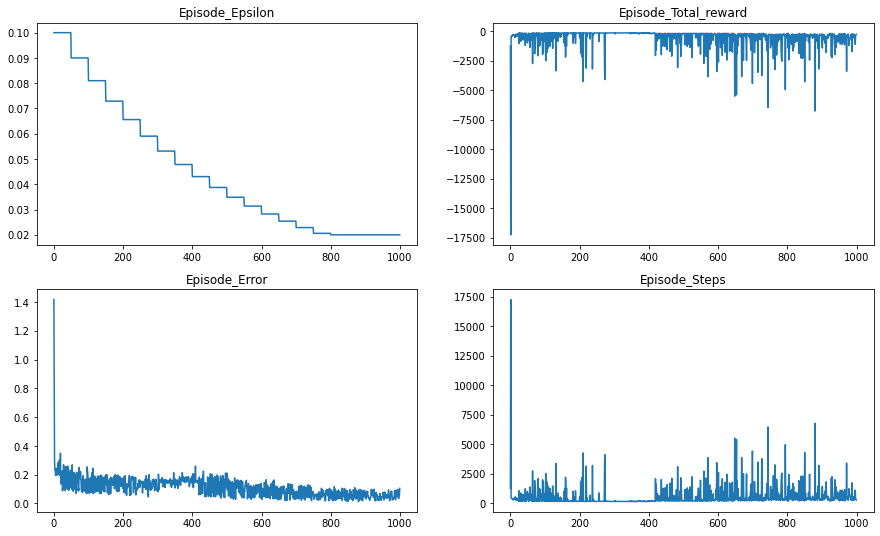

In [14]:
figure, axis = plt.subplots(2, 2, figsize=(15,9))

axis[0, 0].plot(episode_epsilon)
axis[0, 0].set_title("Episode_Epsilon")
  
axis[0, 1].plot(all_rewards)
axis[0, 1].set_title("Episode_Total_reward")
  
axis[1, 0].plot(errors)
axis[1, 0].set_title("Episode_Error")
  
axis[1, 1].plot(episode_steps)
axis[1, 1].set_title("Episode_Steps")

In [15]:
figure.savefig('RBF_SARSA_1.png')